In [1]:
import handcalcs.render
from sympy import *
from random import randint
from math import gcd
import gmpy2
from gmpy2 import mpz
import subprocess
import json
import time
import timeit
import matplotlib.pyplot as plt
import numpy as np

1. Choose two distinct prime numbers p and q

In [99]:
def check_coprime(a, b):
    return gcd(a, b) == 1
    


def get_coprime(n):
    while True:
        c = randint(2, n - 1)
        if check_coprime(n, c):
            return c


def check_prime(n):
    """
    Checks if n is prime using Fermat primality test
    Using the equation:
        a^n-1 = 1 (mod n)
        where:
            a = any coprime
            n = integer
    """
    a = get_coprime(n)
    return True if a**(n - 1) % n == 1 else False


def get_p_and_q():
    l = 50
    u = 500
    p, q = 0, 0
    while True:
        p = randint(l, u)
        p = p if check_prime(p) else 0
        if p > 0 and q > 0:
            return p, q
        q = randint(l, u)
        q = q if check_prime(q) else 0
        if p > 0 and q > 0:
            return p, q

2. Compute n = pq

In [100]:
p, q = get_p_and_q()
n = p * q

3. Compute λ(n), where λ is Carmichael's totient function of the product as λ(n) = lcm(p − 1, q − 1)

In [101]:
def lcm(a, b):
    return abs(a * b) // gcd(a, b)

lambda_n = lcm(p - 1, q - 1)

4. Choose an integer e such that 1 < e < λ(n) and gcd(e, λ(n)) = 1; that is, e and λ(n) are coprime.

In [102]:
def get_e():
    e = 0
    while True:
        e = randint(2, lambda_n - 1)
        if check_coprime(e, lambda_n):
            return e


e = get_e()

5. Determine d as d ≡ e−1 (mod λ(n)); that is, d is the modular multiplicative inverse of e modulo λ(n)

In [103]:
def modular_multiplicative_inverse(a, b):
    """
    Finds where ab (mod b) = 1
    """
    a = a % b
    for i in range(1, b): 
        if ((a * i) % b == 1): 
            return i

        
d = modular_multiplicative_inverse(e, lambda_n)

In [2]:
class PurePythonRSA:
    def __init__(self, p, q):
        self.__n = 0
        self.__e = 0
        self.__d = 0
        self.__make_keys(p, q)
    
    @staticmethod
    def check_coprime(a, b):
        return gcd(a, b) == 1
    
    def get_coprime(self, n):
        while True:
            c = randint(2, n - 1)
            if self.check_coprime(n, c):
                return c

    def check_prime(self, n):
        """
        Checks if n is prime using Fermat primality test
        Using the equation:
            a^n-1 = 1 (mod n)
            where:
                a = any coprime
                n = integer
        """
        a = self.get_coprime(n)
        return True if a**(n - 1) % n == 1 else False
    
    @staticmethod
    def lcm(a, b):
        return abs(a * b) // gcd(a, b)
    
    @staticmethod
    def modular_multiplicative_inverse(a, b):
        """
        Finds where ab (mod b) = 1
        """
        a = a % b
        for i in range(1, b): 
            if ((a * i) % b == 1): 
                return i
    
    def __make_keys(self, p, q):
        self.__n = p * q
        
        lambda_n = self.lcm(p - 1, q - 1)

        for i in range(2, lambda_n):
            if self.check_coprime(i, lambda_n):
                self.__e = i
                break
        
        self.__d = self.modular_multiplicative_inverse(self.__e, lambda_n)
    
    def __encrypt(self, m):
        return m**self.__e % self.__n
    
    def __decrypt(self, c):
        return c**self.__d % self.__n
    
    def encrypt_string(self, p_txt: str) -> list:
        return [self.__encrypt(ord(t)) for t in p_txt]
    
    def decrypt_string(self, c_txt: list) -> str:
        return "".join([chr(self.__decrypt(c)) for c in c_txt])

# make_keys.c

compile command -> `gcc -o make_keys -I/usr/local/include -L/usr/local/lib make_keys.c -lgmp`

```c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <gmp.h>
#include <assert.h>

int main(int argc, char *argv[]){

    mpz_t n, e, d, lambda_n, p, q, i, temp, one;
    int flag;

    // Init all numbers
    mpz_inits(n, e, d, lambda_n, p, q, i, temp, one, NULL);
    mpz_set_ui(one, 1);

    // Set p
    flag = mpz_set_str(p, argv[1], 10);
    assert(flag == 0);

    // Set q
    flag = mpz_set_str(q, argv[2], 10);
    assert(flag == 0);

    // Set n = p * q
    mpz_mul(n, p, q);

    // Set lambda_n = lcm(p - 1, q - 1)
    mpz_sub_ui(p, p, 1);
    mpz_sub_ui(q, q, 1);
    mpz_lcm(lambda_n, p, q);
    mpz_add_ui(p, p, 1);
    mpz_add_ui(q, q, 1);

    // Set e
    mpz_set_ui(i, 2);
    for(i; mpz_cmp(lambda_n, i) > 0; mpz_add_ui(i, i, 1)){
        mpz_gcd(temp, i, lambda_n);
        if(mpz_cmp(temp, one) == 0){
            mpz_set(e, i);
            break;
        }
    }

    // Set d (using modular_multiplicative_inverse built in function)
    mpz_invert(d, e, lambda_n);

    // Output keys to stdout
    printf("{\"n\":");
    mpz_out_str(stdout, 10, n);
    printf(",\"e\":");
    mpz_out_str(stdout, 10, e);
    printf(",\"d\":");
    mpz_out_str(stdout, 10, d);
    printf("}");

    // Clear mpz_t to stop memory leaks
    mpz_clears(n, e, d, lambda_n, p, q, i, temp, one);

}
```

# encrypt.c

compile command -> `gcc -o encrypt -I/usr/local/include -L/usr/local/lib encrypt.c -lgmp`

```c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <gmp.h>
#include <assert.h>
#include <string.h>

int main(int argc, char *argv[]){

    mpz_t n, e, c, m, temp;
    int flag;

    // Init all numbers
    mpz_inits(n, e, c, m, temp, NULL);

    // Set n
    flag = mpz_set_str(n, argv[1], 10);
    assert(flag == 0);

    // Set e
    flag = mpz_set_str(e, argv[2], 10);
    assert(flag == 0);

    // Set message
    char message[1024];
    strcpy(message, argv[3]);

    // Encrypt message
    for(int i = 0; i < strlen(message); i++){
        mpz_set_ui(m, (int)message[i]);
        mpz_powm(temp, m, e, n);
        mpz_out_str(stdout, 10, temp);
        printf("\n");
    }

    // Clear mpz_t to stop memory leaks
    mpz_clears(n, e, m, temp, c);

}
```

# decrypt.c

compile command -> `gcc -o decrypt -I/usr/local/include -L/usr/local/lib decrypt.c -lgmp`

```c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <gmp.h>
#include <assert.h>
#include <string.h>

int main(int argc, char *argv[]){

    mpz_t n, d, c, temp;
    int flag;

    // Init all numbers
    mpz_inits(n, d, c, temp, NULL);

    // Set n
    flag = mpz_set_str(n, argv[1], 10);
    assert(flag == 0);

    // Set d
    flag = mpz_set_str(d, argv[2], 10);
    assert(flag == 0);

    // Decrypt letter
    for(int i = 3; i < argc; i++){
        mpz_set_str(c, argv[i], 10);
        mpz_powm(temp, c, d, n);
        mpz_out_str(stdout, 10, temp);
        printf("\n");
    }

    // Clear mpz_t to stop memory leaks
    mpz_clears(n, d, c, temp);

}
```

In [25]:
class GMPYRSA:
    def __init__(self, p, q):
        p, q = mpz(p), mpz(q)
        self.__n = 0
        self.__e = 0
        self.__d = 0
        self.__make_keys(p, q)
        self.__p = p
        self.__q = q
        self.__dp = gmpy2.t_mod(self.__d, self.__p - 1)
        self.__dq = gmpy2.t_mod(self.__d, self.__q - 1)
        self.__qinv = gmpy2.powmod(self.__q, - 1, self.__p)

    def __make_keys(self, p, q):
        self.__n = gmpy2.mul(p, q)

        lambda_n = gmpy2.lcm(gmpy2.sub(p, 1), gmpy2.sub(q, 1))

        for i in range(2, lambda_n):
            temp = gmpy2.gcd(mpz(i), lambda_n)
            if temp == 1:
                self.__e = mpz(i)
                break

        self.__d = gmpy2.invert(self.__e, lambda_n)

    def encrypt(self, p_txt: str) -> list:
        return [gmpy2.powmod(ord(i), self.__e, self.__n) for i in p_txt]
    
    def decrypt(self, c_txt: list) -> str:
        return "".join([chr(gmpy2.powmod(mpz(i), self.__d, self.__n)) for i in c_txt])

    def decrypt_optimised(self, c_txt: list) -> str:
        de = []
        for c in c_txt:
            c = mpz(c)
            m1 = gmpy2.powmod(c, self.__dp, self.__p)
            m2 = gmpy2.powmod(c, self.__dq, self.__q)

            if m1 > m2:
                h = gmpy2.t_mod(gmpy2.mul(self.__qinv, gmpy2.sub(m1, m2)), self.__p)
            else:
                h = gmpy2.t_mod(gmpy2.mul(self.__qinv, gmpy2.sub(gmpy2.add(m1, gmpy2.mul(gmpy2.c_div(self.__q, self.__p), self.__p)), m2)), self.__p)

            m = gmpy2.t_mod(gmpy2.add(m2, gmpy2.mul(h, self.__q)), self.__n)
            de.append(m)

        return "".join([chr(i) for i in de])

In [5]:
def c_make_keys(p, q):
    process = subprocess.run(
        [
            "make_keys.exe", 
            p, 
            q
        ], 
        stdout=subprocess.PIPE
    )
    
    return json.loads(process.stdout.decode())
    

def c_encrypt(keys, message):
    process = subprocess.run(
        [
            "encrypt.exe",
            str(keys["n"]),
            str(keys["e"]),
            message
        ],
        stdout=subprocess.PIPE
    )

    return process.stdout.decode().split("\n")[:-1]

def c_decrypt(keys, encrypted):
    decrypted = subprocess.run(
        [
            "decrypt.exe", 
            str(keys["n"]), 
            str(keys["d"]), 
            *encrypted
        ], 
        stdout=subprocess.PIPE
    )

    return "".join([chr(int(i)) for i in decrypted.stdout.decode().split("\n")[:-1]])

In [10]:
p = "144109489781429832141928564718403405662340290289501393367141733385194527879619117471"\
    "5480090706272114362096699688582610014497160530086573446557903757611295870432080261289"\
    "27293195865680484583447477423282847955473747573985306614797957489285011655774639966546"\
    "307764562522552360217820348205048703551045931562818129"

q = "49918173965411288634122456903120210742549881301322241995649567584949320271616122461893"\
    "84263603860973937353778410734002718736658543469922088068797551535435381993621837727113"\
    "04486182031002048213371215247458326787264309527462879515397458028975200883407739802734"\
    "86908681136932656205802742665171891453117618011969"

In [27]:
gmpyrsa = GMPYRSA(p, q)
ks = c_make_keys(p, q)

message = {"small": {"drops": {"axe": 2},"xp": 1},"medium": {"drops": {"fire": 50,"lightning": 25,"sword": 2},"xp": 10},"large":{"drops":{"gold_chest": 25,"sword": 10},"xp": 50}}
message = json.dumps(message)
encrypted_message = c_encrypt(ks, message)

In [24]:
%timeit gmpyrsa.encrypt(message)
%timeit c_encrypt(ks, message)

1.09 ms ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
27.1 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit gmpyrsa.decrypt(encrypted_message)
%timeit c_decrypt(ks, encrypted_message)
%timeit gmpyrsa.decrypt_optimised(encrypted_message)

420 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
353 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
122 ms ± 4.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
def exec_time(exec_num):
    py_en_times = []
    c_en_times = []

    py_de_times = []
    c_de_times = []
    py_de_op_times = []

    for i in range(10):
        message = {k: v for k, v in zip(range(10 * (i + 1)), range(10 * (i + 1)))}
        message = json.dumps(message)
        encrypted_message = c_encrypt(c_make_keys(p, q), message)

        py_en = timeit.timeit("gmpyrsa.encrypt(message)", globals=globals(), number=exec_num)
        c_en = timeit.timeit("c_encrypt(ks, message)", globals=globals(), number=exec_num)

        py_de = timeit.timeit("gmpyrsa.decrypt(encrypted_message)", globals=globals(), number=exec_num)
        c_de = timeit.timeit("c_decrypt(ks, encrypted_message)", globals=globals(), number=exec_num)
        py_de_op = timeit.timeit("gmpyrsa.decrypt_optimised(encrypted_message)", globals=globals(), number=exec_num)

        py_en_times.append(py_en)
        py_de_times.append(py_de)
        py_de_op_times.append(py_de_op)

        c_en_times.append(c_en)
        c_de_times.append(c_de)

        print(i, end="")
    
    return py_en_times, py_de_times, c_en_times, c_de_times, py_de_op_times

<IPython.core.display.Javascript object>


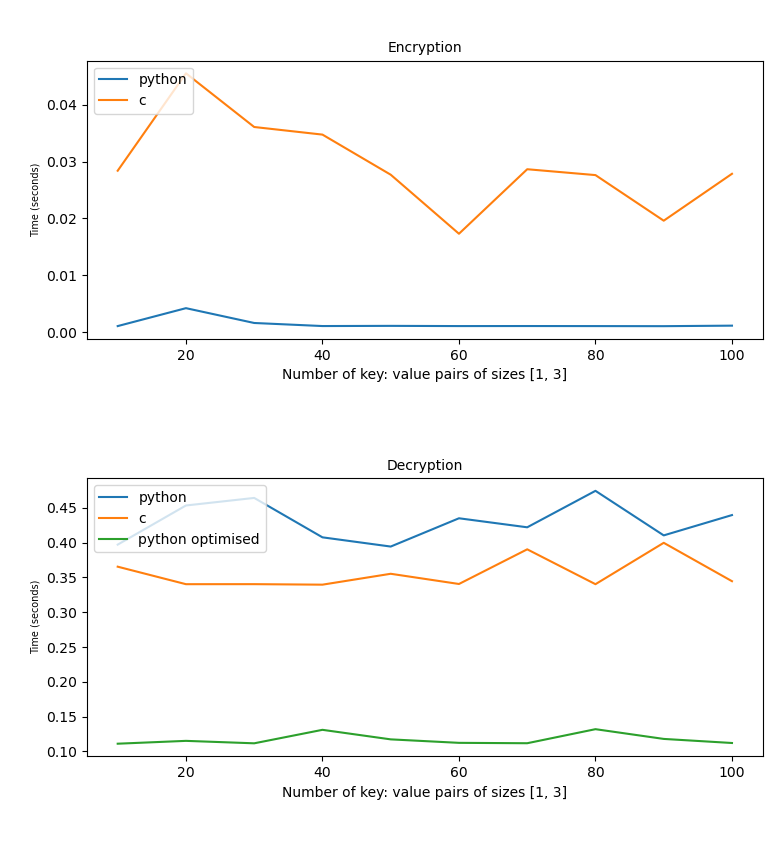

0123456789

In [31]:
%matplotlib notebook

x_axis = [10 * (i + 1) for i in range(10)]

fig = plt.figure()

num_of_exec = 1

py_en_data, py_de_data, c_en_data, c_de_data, py_de_op_data = [list(map(lambda x: x/num_of_exec, i)) for i in exec_time(num_of_exec)]
en_ax = plt.subplot(2, 1, 1)
en_ax.set_title("Encryption", fontsize=10)
en_ax.set_xlabel("Number of key: value pairs of sizes [1, 3]")
en_ax.set_ylabel(f"Time (seconds)", fontsize=7)

de_ax = plt.subplot(2, 1, 2)
de_ax.set_title("Decryption", fontsize=10)
de_ax.set_xlabel("Number of key: value pairs of sizes [1, 3]")
de_ax.set_ylabel("Time (seconds)", fontsize=7)

py_en, = en_ax.plot(x_axis, py_en_data, label="python")
py_de, = de_ax.plot(x_axis, py_de_data, label="python")

c_en, = en_ax.plot(x_axis, c_en_data, label="c")
c_de, = de_ax.plot(x_axis, c_de_data, label="c")

py_de_op, = de_ax.plot(x_axis, py_de_op_data, label="python optimised")

en_ax.legend(loc="upper left")
de_ax.legend(loc="upper left")
plt.tight_layout()
plt.show()